In [22]:
import os,sys
import glob
from osgeo import gdal
# import datetime 
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
%matplotlib  widget

In [3]:
# Need this function to convert datetime objects to decimal years. Got this off of stackexchange. 
def datetime2year(dt): 
    year_part = dt - datetime(year=dt.year, month=1, day=1)
    year_length = (
        datetime(year=dt.year + 1, month=1, day=1)
        - datetime(year=dt.year, month=1, day=1)
    )
    return dt.year + year_part / year_length

In [4]:
# this one is to pick out the dates 
datesDir = '/data/ocp4/LagunaSalada/Data_and_Figs/cropped_9000_1800_18000_3600/'

# larger cropped area with western mountains 
dx = 4000
dy = 1100

# load in dates, make sure they are in order
dates = [os.path.basename(x) for x in glob.glob(datesDir+"SLC_vh/2*")]; dates = sorted(dates)
nd = len(dates); numIgrams = nd-1

In [8]:
# Define the reference point we want to use. Will be the same with MintPy.
refX = 3694
refY = 443

In [9]:
# dates is a list of strings, convert strings to datetime objects 
slc_dates=[]
for i in range(0,len(dates)):
    slc_dates.append(datetime.strptime(str(dates[i]).replace('\n',''), '%Y%m%d'))
# convert to floats 
slc_dates_floats = np.ndarray((len(slc_dates),1),dtype='float')
for i in range(len(slc_dates)):
    slc_dates_floats[i] = datetime2year(slc_dates[i]) # now an array of floats in years
# take numIgrams and pull out the igram_dates, corresponding to the second/last day of each igram
igram_dates = slc_dates[1::] # using the second SLC date per Rowena's suggestion
dt1 = np.diff(slc_dates) # calculate dt between slcs, these are now timedelta objects
# convert to floats 
dt_all = np.zeros([len(dt1),1])
for i in range(len(dt_all)):
    dt_all[i] = dt1[i].days #/365.25 # dt is now an array of floats (years btw slc acquisitions)
print('slc_dates: '+str(np.shape(slc_dates)[0]))
print('igram_dates: '+str(np.shape(igram_dates)[0]))

slc_dates: 211
igram_dates: 210


In [10]:
start_indices = [0,         52, 107, 62, 172, 60]
end_indices =   [numIgrams, 73, 153, 76, 189, 70]
num_intervals = len(start_indices)

for i in range(num_intervals):
    print('interval '+str(i)+': '+str(dates[start_indices[i]]+' - '+str(dates[end_indices[i]])))
print('\ntotal duration of this study: '+str((igram_dates[-1]-igram_dates[0]).days/365.25)+' years')

interval 0: 20170510 - 20220108
interval 1: 20190205 - 20190921
interval 2: 20200412 - 20210119
interval 3: 20190617 - 20191009
interval 4: 20210513 - 20210829
interval 5: 20190524 - 20190903

total duration of this study: 4.632443531827516 years


In [11]:
# load the disp rate and rmse files
j=5
saveDir =    '/data/ocp4/LagunaSalada/Data_and_Figs/12_rate_inversions/disp_rate_maps_with_western_mtns/'
saveFile = saveDir + dates[start_indices[j]]+'-'+dates[end_indices[j]]+'_ref_x'+str(refX)+'_y'+str(refY)+'/'
fileName = 'weighted_rates_NO_phs_jump_cutoff.r4'
wrapErrFileName = 'num_wrap_errs.r4'
stdFileName = 'rate_std.r4'

f1 = gdal.Open(saveFile+fileName, gdal.GA_ReadOnly)
disp_rates = f1.ReadAsArray()
f1 = None
print('Disp rate map loaded.')

f1 = gdal.Open(saveFile+wrapErrFileName, gdal.GA_ReadOnly)
num_errs = f1.ReadAsArray()
f1 = None
print('Num wrap errors loaded.')

f1 = gdal.Open(saveFile+stdFileName, gdal.GA_ReadOnly)
rate_std = f1.ReadAsArray()
f1 = None
print('Num wrap errors loaded.')

Disp rate map loaded.
Num wrap errors loaded.
Num wrap errors loaded.


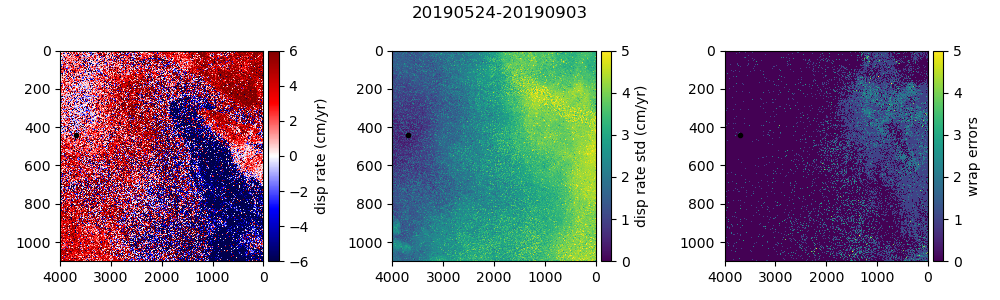

0.0


In [12]:
# plot what I just loaded in.
plt.figure(figsize=(10,3),tight_layout=True)
plt.subplot(1,3,1)
plt.imshow(disp_rates-np.mean(disp_rates), aspect='auto', cmap='seismic',vmin=-6.0,vmax=6.0,\
            interpolation='nearest')
plt.plot(refX,refY,'k.')
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
plt.xlim([dx,0]); plt.ylim([dy,0])

plt.subplot(1,3,2)
plt.imshow(rate_std, aspect='auto', cmap='viridis',vmin=0,vmax=5.0,\
            interpolation='nearest')
plt.plot(refX,refY,'k.')
# plt.plot(3519,938,'m.')
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate std (cm/yr)')
plt.xlim([dx,0]); plt.ylim([dy,0])

plt.subplot(1,3,3)
plt.imshow(num_errs, aspect='auto', cmap='viridis',vmin=0,vmax=5,\
            interpolation='nearest')
plt.plot(refX,refY,'k.')
plt.colorbar(orientation='vertical',pad=0.02,label='wrap errors')
plt.xlim([dx,0]); plt.ylim([dy,0])
plt.suptitle(dates[start_indices[j]]+'-'+dates[end_indices[j]])
plt.show()
print(disp_rates[refY,refX])

In [13]:
# multilooked ALL pixels 
mintpy_file = '/home/ocp4/data/LagunaSalada/Data_and_Figs/12_rate_inversions/simpler_mintpy_results/20190524-20190903_ref_x3694_y443/velocity.h5'
band='velocity'
ds = gdal.Open("HDF5:\"{}\"://{}".format(mintpy_file,band))
mintpy_rates = ds.GetRasterBand(1).ReadAsArray()
mintpy_rates_cm = -mintpy_rates*100 # convert from m/yr to cm/yr 

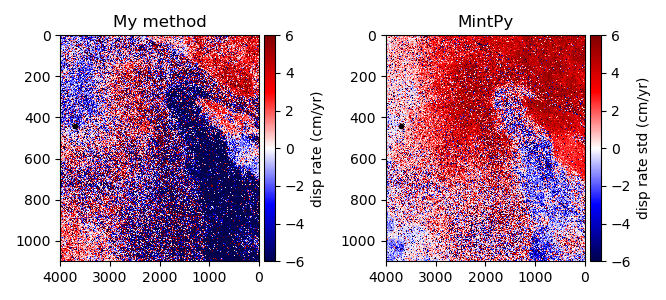

In [15]:
# plot what I just loaded in.
plt.figure(figsize=(6.6667,3),tight_layout=True)
plt.subplot(1,2,1)
plt.imshow(disp_rates, aspect='auto', cmap='seismic',vmin=-6.0,vmax=6.0,\
            interpolation='nearest')
plt.plot(refX,refY,'k.')
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
plt.xlim([dx,0]); plt.ylim([dy,0])
plt.title('My method')

plt.subplot(1,2,2)
plt.imshow(mintpy_rates_cm, aspect='auto', cmap='seismic',vmin=-6.0,vmax=6.0,\
            interpolation='nearest')
plt.plot(refX,refY,'k.')
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate std (cm/yr)')
plt.xlim([dx,0]); plt.ylim([dy,0])
plt.title('MintPy')

plt.show()

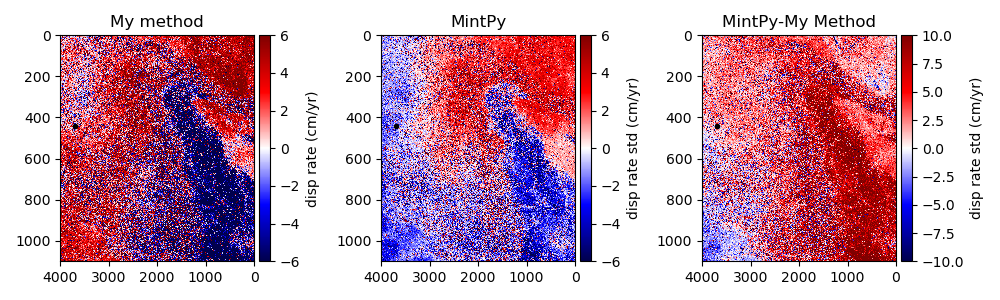

-0.0


In [20]:
# plot what I just loaded in.
plt.figure(figsize=(10,3),tight_layout=True)
plt.subplot(1,3,1)
plt.imshow(disp_rates-np.mean(disp_rates), aspect='auto', cmap='seismic',vmin=-6.0,vmax=6.0,\
            interpolation='nearest')
plt.plot(refX,refY,'k.')
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate (cm/yr)')
plt.xlim([dx,0]); plt.ylim([dy,0])
plt.title('My method')

plt.subplot(1,3,2)
plt.imshow(mintpy_rates_cm-np.mean(mintpy_rates_cm), aspect='auto', cmap='seismic',vmin=-6.0,vmax=6.0,\
            interpolation='nearest')
plt.plot(refX,refY,'k.')
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate std (cm/yr)')
plt.xlim([dx,0]); plt.ylim([dy,0])
plt.title('MintPy')

plt.subplot(1,3,3)
plt.imshow(mintpy_rates_cm-disp_rates, aspect='auto', cmap='seismic',vmin=-10.0,vmax=10.0,\
            interpolation='nearest')
plt.plot(refX,refY,'k.')
plt.colorbar(orientation='vertical',pad=0.02,label='disp rate std (cm/yr)')
plt.xlim([dx,0]); plt.ylim([dy,0])
plt.title('MintPy-My Method')

plt.show()

print(mintpy_rates_cm[refY,refX]-disp_rates[refY,refX])

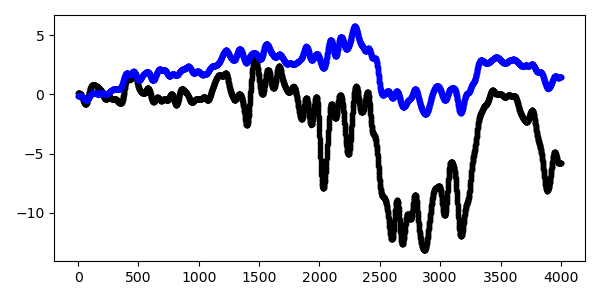

In [28]:
plt.figure(figsize=(6,3),tight_layout=True)
filt_transect   = gaussian_filter(disp_rates[500,:],sigma=20)
filt_transect_2 = gaussian_filter(mintpy_rates_cm[500,:],sigma=20)
plt.plot(np.arange(4000,0,-1),filt_transect,'k.')
plt.plot(np.arange(4000,0,-1),filt_transect_2,'b.')
plt.show()

In [37]:
yearly_rate = 10.0 # this is in cm/yr
daily_rate = yearly_rate/365.25

timespans = np.array([6.0, 12.0, 24.0, 36.0, 48.0, 96.0, 144.0])

ifgs_LS_added_disps = timespans * daily_rate
print(ifgs_LS_added_disps)

[0.16427105 0.32854209 0.65708419 0.98562628 1.31416838 2.62833676
 3.94250513]
